In [1]:
using Pkg
Pkg.activate("psyc261")
using Distributions
using ProgressMeter
using Gen, Plots
using Parameters
using PyCall
using PyPlot
using JLD2

ENV["PYTHON"] = "/Users/dongyu/opt/anaconda3/envs/modeling/bin/python"
println(PyCall.python)
include("draw.jl");
include("truncatednorm.jl")

  Activating project at `~/Documents/Github/final_project/lab-05/psyc261`


/Users/dongyu/opt/anaconda3/envs/modeling/bin/python


In [2]:
np = pyimport("numpy")
mi = pyimport("mitsuba")
plt = pyimport("matplotlib.pyplot")

PyObject <module 'matplotlib.pyplot' from '/Users/dongyu/opt/anaconda3/envs/modeling/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [3]:
py"""
import numpy as np
import mitsuba as mi
mi.set_variant("scalar_rgb")
from mitsuba import ScalarTransform4f as T
def initialize_scene(wall_color, floor_color, object_color, object_type, object_scale):

    d = {
        "type": "scene",
        "integrator": {
            'type': 'path',
            'max_depth': 6,
        },
        
        'sensor': {
            'type': 'perspective',
            'fov_axis': 'smaller',
            'near_clip': 0.001,
            'far_clip': 100.0,
            'focus_distance': 1000,
            'fov': 39.3077,
            'to_world': T.look_at(
                origin=[0, 0, 4],
                target=[0, 0, 0],
                up=[0, 1, 0]
            ),
            'sampler': {
                'type': 'independent',
                'sample_count': 16
            },
            'film': {
                'type': 'hdrfilm',
                'width' : 64,
                'height': 64,
                'rfilter': {
                    'type': 'tent',
                },
                'pixel_format': 'rgb',
                'component_format': 'float32',
            }
        },

        # -------------------- BSDFs --------------------

        'white': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.885809, 0.698859, 0.666422],
            }
        },

        'green': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.105421, 0.37798, 0.076425],
            }
        },
        'Red': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.570068, 0.0430135, 0.0443706],
            }
        },
        
        # -------------------- Light --------------------
        'light': {
            'type': 'rectangle',
            'to_world': T.translate([0.0, 0.99, 0.01]).rotate([1, 0, 0], 90).scale([0.23, 0.19, 0.19]),
            'bsdf': {
                'type': 'ref',
                'id': 'white'
            },
            'emitter': {
                'type': 'area',
                'radiance': {
                    'type': 'rgb',
                    'value': [18.387, 13.9873, 6.75357],
                }
            }
        },

        'floor': {
            'type': 'obj',
            'filename': 'meshes/cbox_floor.obj',
            'floor-bsdf': {
                'type' : 'ref',
                'id' : floor_color
            }
        },

        'ceiling': {
            'type': 'obj',
            'filename': 'meshes/cbox_ceiling.obj',
            'ceiling-bsdf': {
                'type' : 'ref',
                'id' : wall_color
            }
        },
        
        'rear': {
            'type': 'obj',
            'filename': 'meshes/cbox_back.obj',
            'back-bsdf': {
                'type' : 'ref',
                'id' : wall_color
            }
        },

        'leftwall': {
            'type': 'obj',
            'filename': 'meshes/cbox_greenwall.obj',
            'greenwall-bsdf': {
                'type' : 'ref',
                'id' : wall_color
            }
        },
        'rightwall': {
            'type': 'obj',
            'filename': 'meshes/cbox_redwall.obj',
            'redwall-bsdf': {
                'type' : 'ref',
                'id' : wall_color
            }
        },
        
        'left_object': {
            'type': object_type,
            'to_world': T.translate([0, -0.5, 0]).scale(object_scale),
            'leftobject-bsdf': {
                'type' : 'ref',
                'id' : object_color
            }
        },

    }
    return d

"""

In [4]:
# x_poses = [-0.5,0,0.5]
# y_poses = [-0.5,0,0.5]
# z_poses = [-0.5,0,0.5]
wall_colors = ["white", "green", "Red"]
floor_colors = ["white", "green", "Red"]
object_colors = ["white", "green", "Red"]
object_types = ["sphere", "rectangle"]
object_scales = [0.3, 0.4, 0.5, 0.6, 0.7]
spp = 128


128

In [14]:
mitsuba_data = []
for (wall_color, floor_color, object_color, object_type, object_scale) in Iterators.product(wall_colors, floor_colors, object_colors, object_types, object_scales)
    scene_d = py"initialize_scene"(wall_color, floor_color, object_color, object_type, object_scale)
    # load the scene using the load_dict function
    scene = mi.load_dict(scene_d)
    # render the scene
    image = mi.render(scene, spp=spp)
    bitmap = mi.Bitmap(image).convert(srgb_gamma=true)
    mu = @pycall np.array(bitmap)::Array{Float32, 3}
    mu = np.clip(mu, 0, 1)
    mu = reshape(mu, (1, 64, 64, 3))
    push!(mitsuba_data, mu)
end
mitsuba_data = np.concatenate(mitsuba_data, axis=0)
# save mitsuba_data
save("mitsuba_data.jld2", "mitsuba_data", mitsuba_data)
;

In [78]:
# load mitsuba_data
ori_mitsuba_data = load("mitsuba_data.jld2", "mitsuba_data")
;

In [79]:
# convert the values in inferred_images to be between -1 and 1
mitsuba_data = ori_mitsuba_data .* 2 .- 1
;

In [80]:
mitsuba_data = [reshape(mitsuba_data[i,:,:,:], (64*64*3,1)) for i in 1:size(mitsuba_data)[1]]

270-element Vector{Matrix{Float32}}:
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 ⋮
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]
 [-1.0; -1.0; … ; -1.0; -1.0;;]

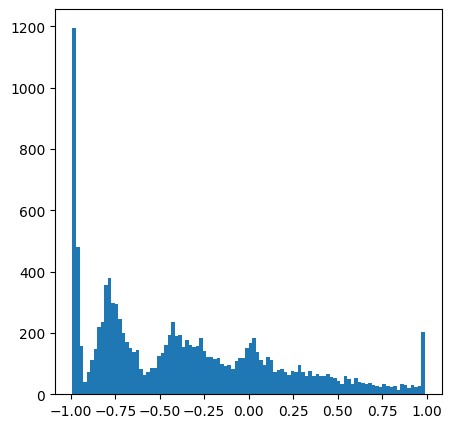

In [85]:
# check the distribution of the pixel values in one mitsuba_data
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(mitsuba_data[2], bins=100)
display(fig)


In [83]:
py"""
def remap_array(values, old_min, old_max, new_min, new_max):
    # Normalize to [0, 1]
    normalized = (values - old_min) / (old_max - old_min)
    # Scale to new range
    return new_min + normalized * (new_max - new_min)
"""

In [84]:
# clip mitsuba_data to be between -0.99 to -0.625
mitsuba_data = [np.clip(mitsuba_data[i], -0.99, 0) for i in 1:size(mitsuba_data)[1]]
# remap mitsuba_data to be between -1 to 1
mitsuba_data = [py"remap_array"(mitsuba_data[i], -0.99, 0, -0.99, 0.99) for i in 1:size(mitsuba_data)[1]]
;


In [42]:
py"""
import numpy as np
import matplotlib.pyplot as plt
def show_images_grid(imgs_, num_images=25,random=True,idxs=None):
  imgs_ = imgs_.astype(np.float32)
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  fig, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()
  if random:
    if idxs is None:
      rand_idxs = np.random.choice(imgs_.shape[0], size=num_images, replace=False)
    else:
      rand_idxs = idxs
  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      if random:
        ax.imshow(imgs_[rand_idxs[ax_i]], cmap='Greys_r', interpolation='nearest')
      else:
        ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')
  return fig
"""


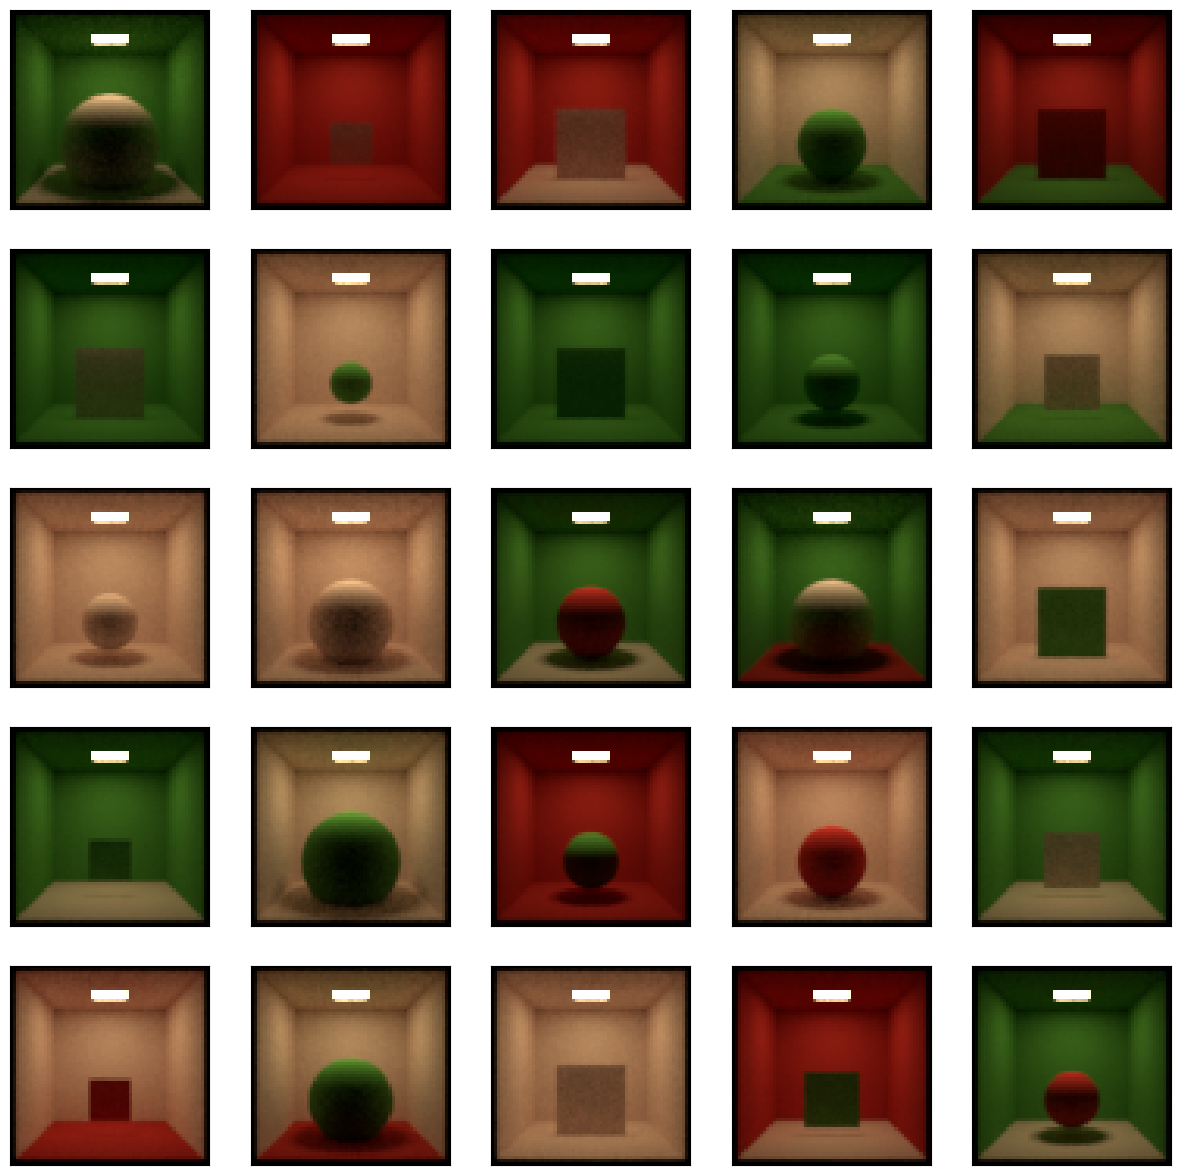

In [75]:

rand_idxs = np.random.choice(270, size=25)
display(py"show_images_grid"(ori_mitsuba_data, 25, true, rand_idxs))

In [11]:
function transform!(scene_d, object, scale, translation)
    transformation = @pycall mi.Transform4f.translate(translation).scale(scale)::PyObject
    object_dict = PyObject(get(scene_d, object))
    set!(object_dict, "to_world", transformation)
    set!(scene_d, object, object_dict)
    return scene_d
end

function render_bitmap(modelparams)
    image = @pycall mi.render(modelparams.scene, spp=modelparams.spp)::PyObject
    bitmap = @pycall mi.Bitmap(image).convert(srgb_gamma=true)::PyObject
    return bitmap
end

function render(modelparams)
    bitmap = render_bitmap(modelparams)
    mu = @pycall np.array(bitmap)::Array{Float32, 3}
    return mu[:, :, 1]
end

function update_scene_parameters!(scene_dict, wall_color, floor_color, object_color, object_type, object_scale)
    scene_dict["ceiling"]["ceiling-bsdf"]["id"] = wall_color
    scene_dict["rear"]["back-bsdf"]["id"] = wall_color
    scene_dict["leftwall"]["greenwall-bsdf"]["id"] = wall_color
    scene_dict["rightwall"]["redwall-bsdf"]["id"] = wall_color

    # Update floor color
    scene_dict["floor"]["floor-bsdf"]["id"] = floor_color
    # Update object color
    scene_dict["left_object"]["leftobject-bsdf"]["id"] = object_color

    # Update object type - this would require additional logic depending on how you want to handle different object types
    scene_dict["left_object"]["type"] = object_type

    scene_dict["left_object"]["to_world"] = mi.Transform4f.translate([0, -0.5, 0]).scale(object_scale)

    return scene_dict
end
;

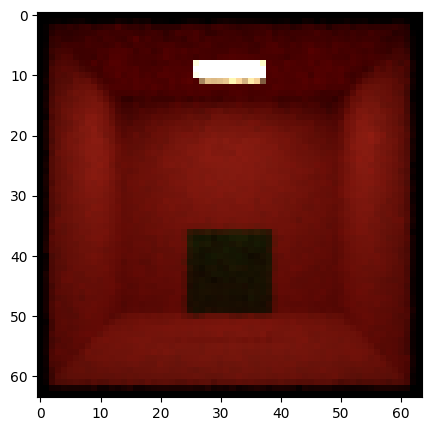

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(inferred_images[30, :, :, :], cmap="Greys_r", interpolation="nearest")
display(fig)

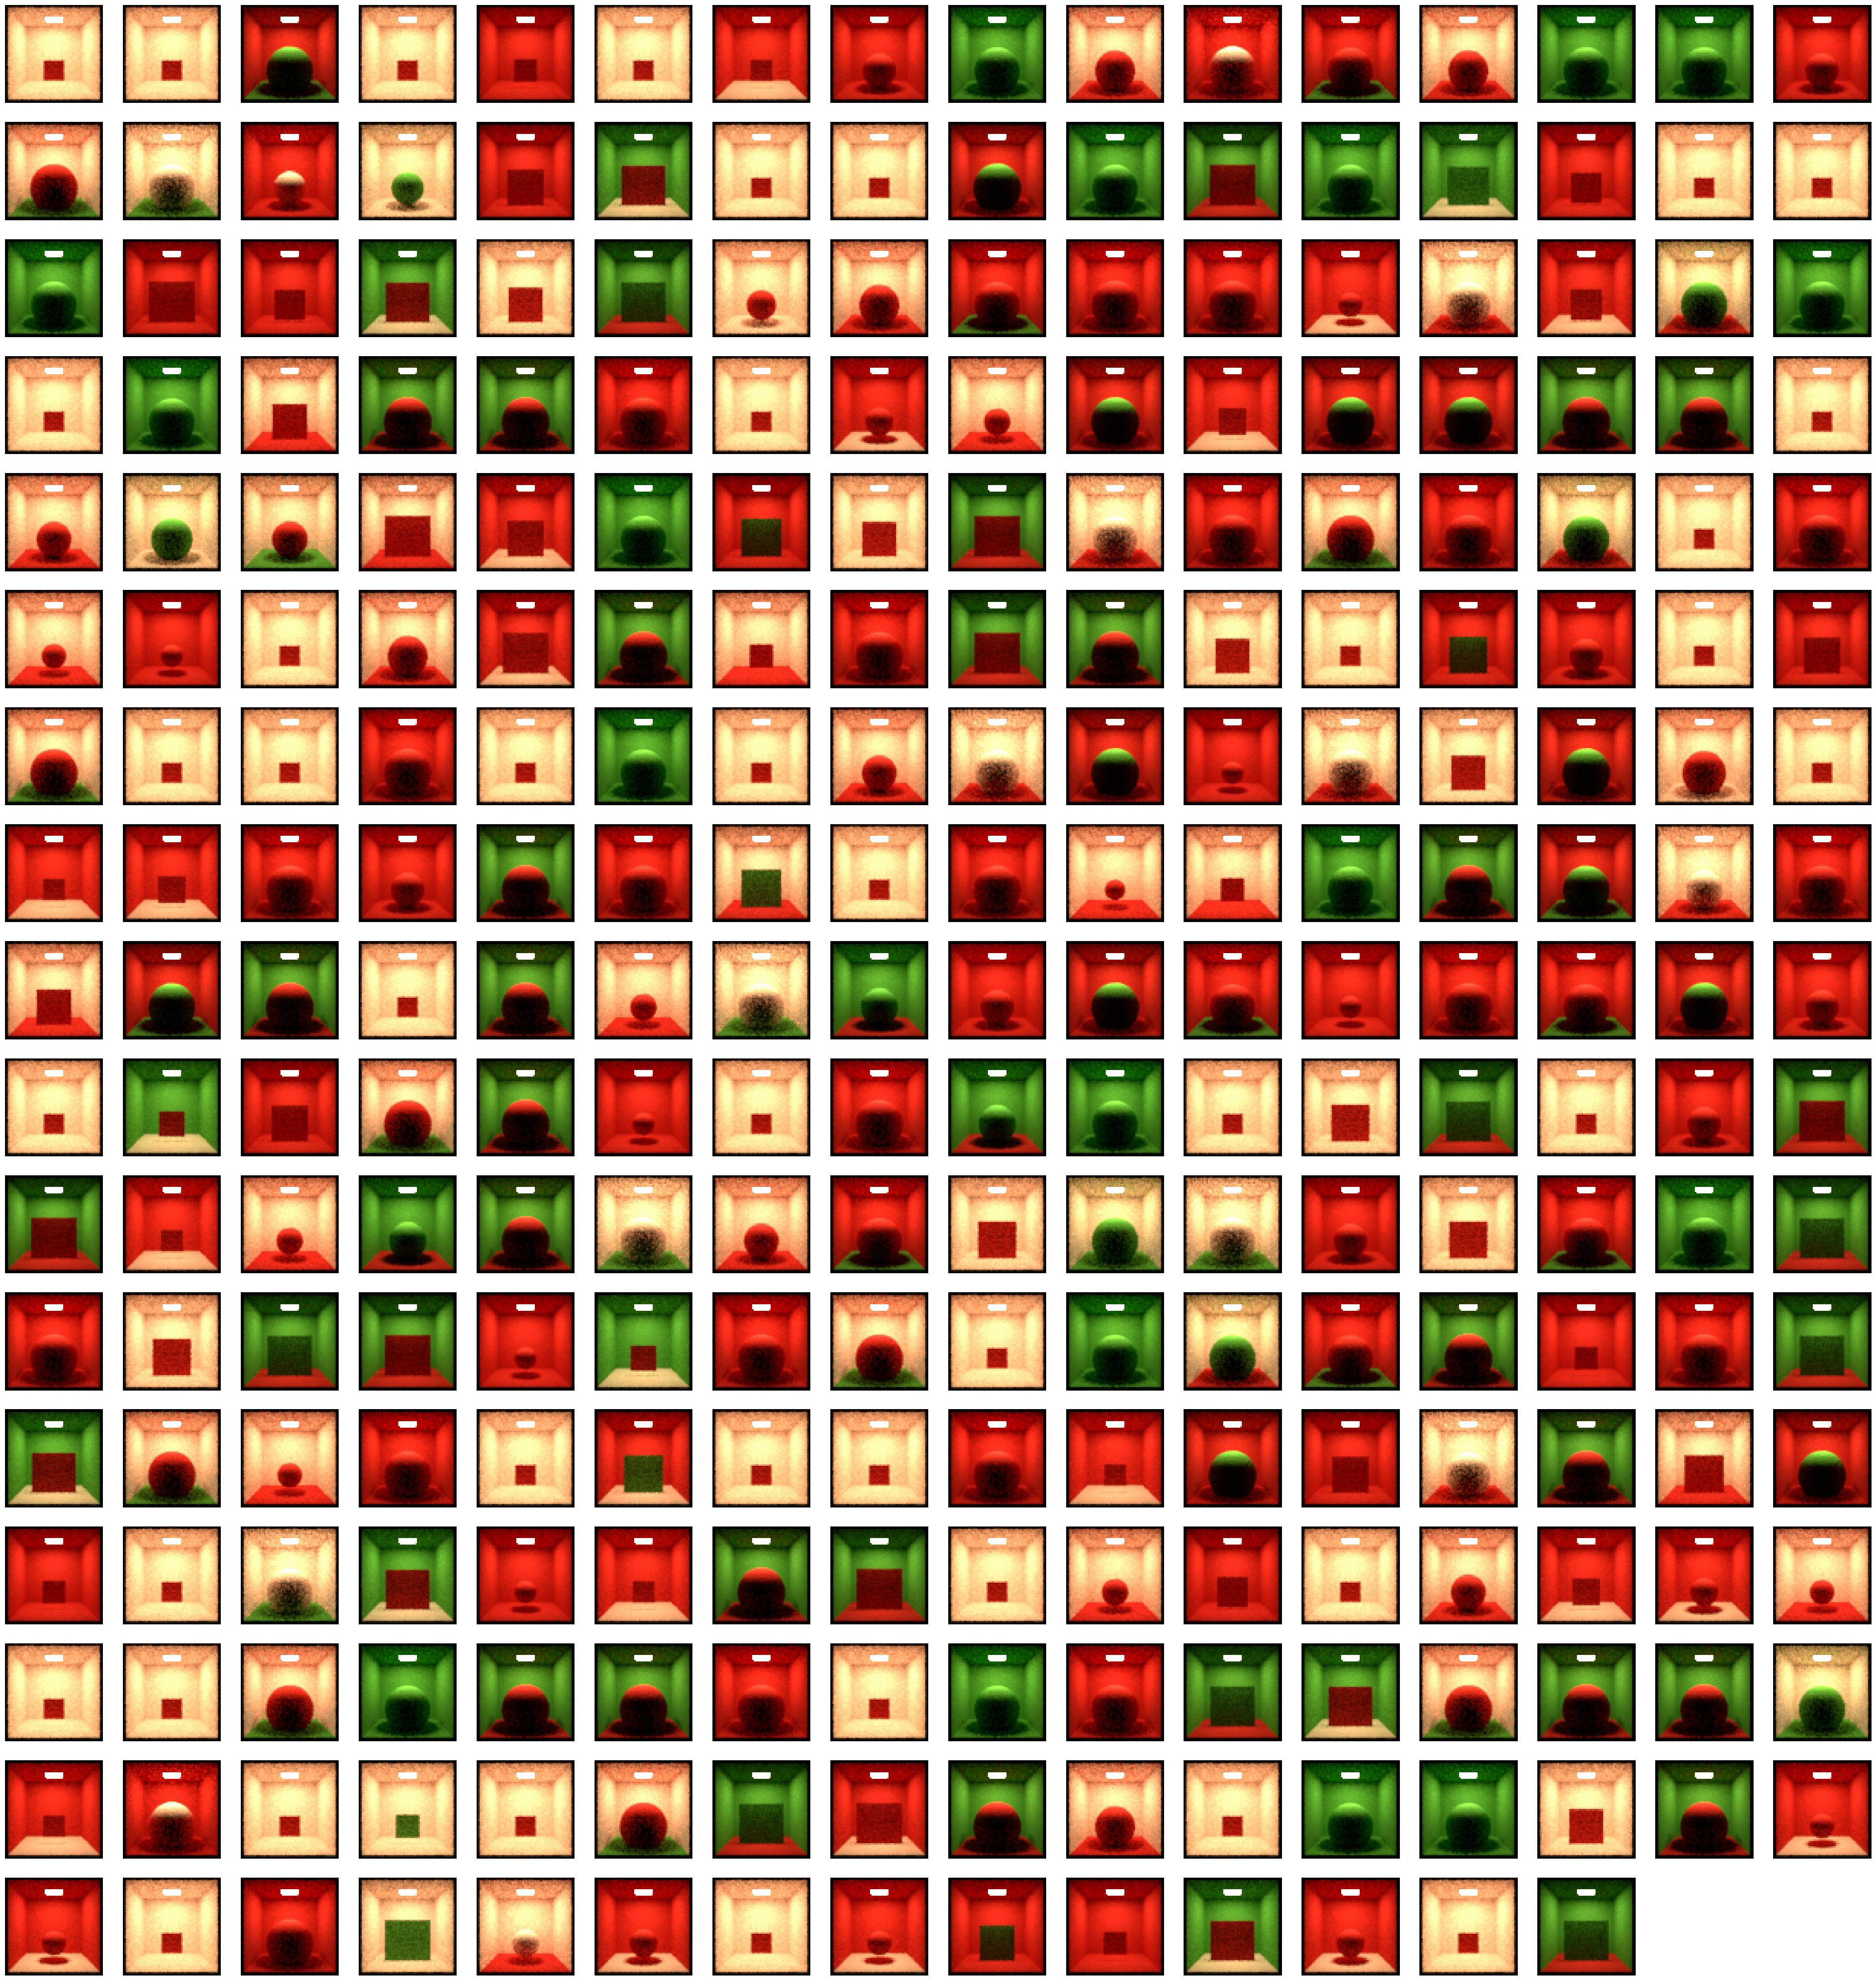

In [80]:
display(py"show_images_grid"(replayed_inferences, 270, false))

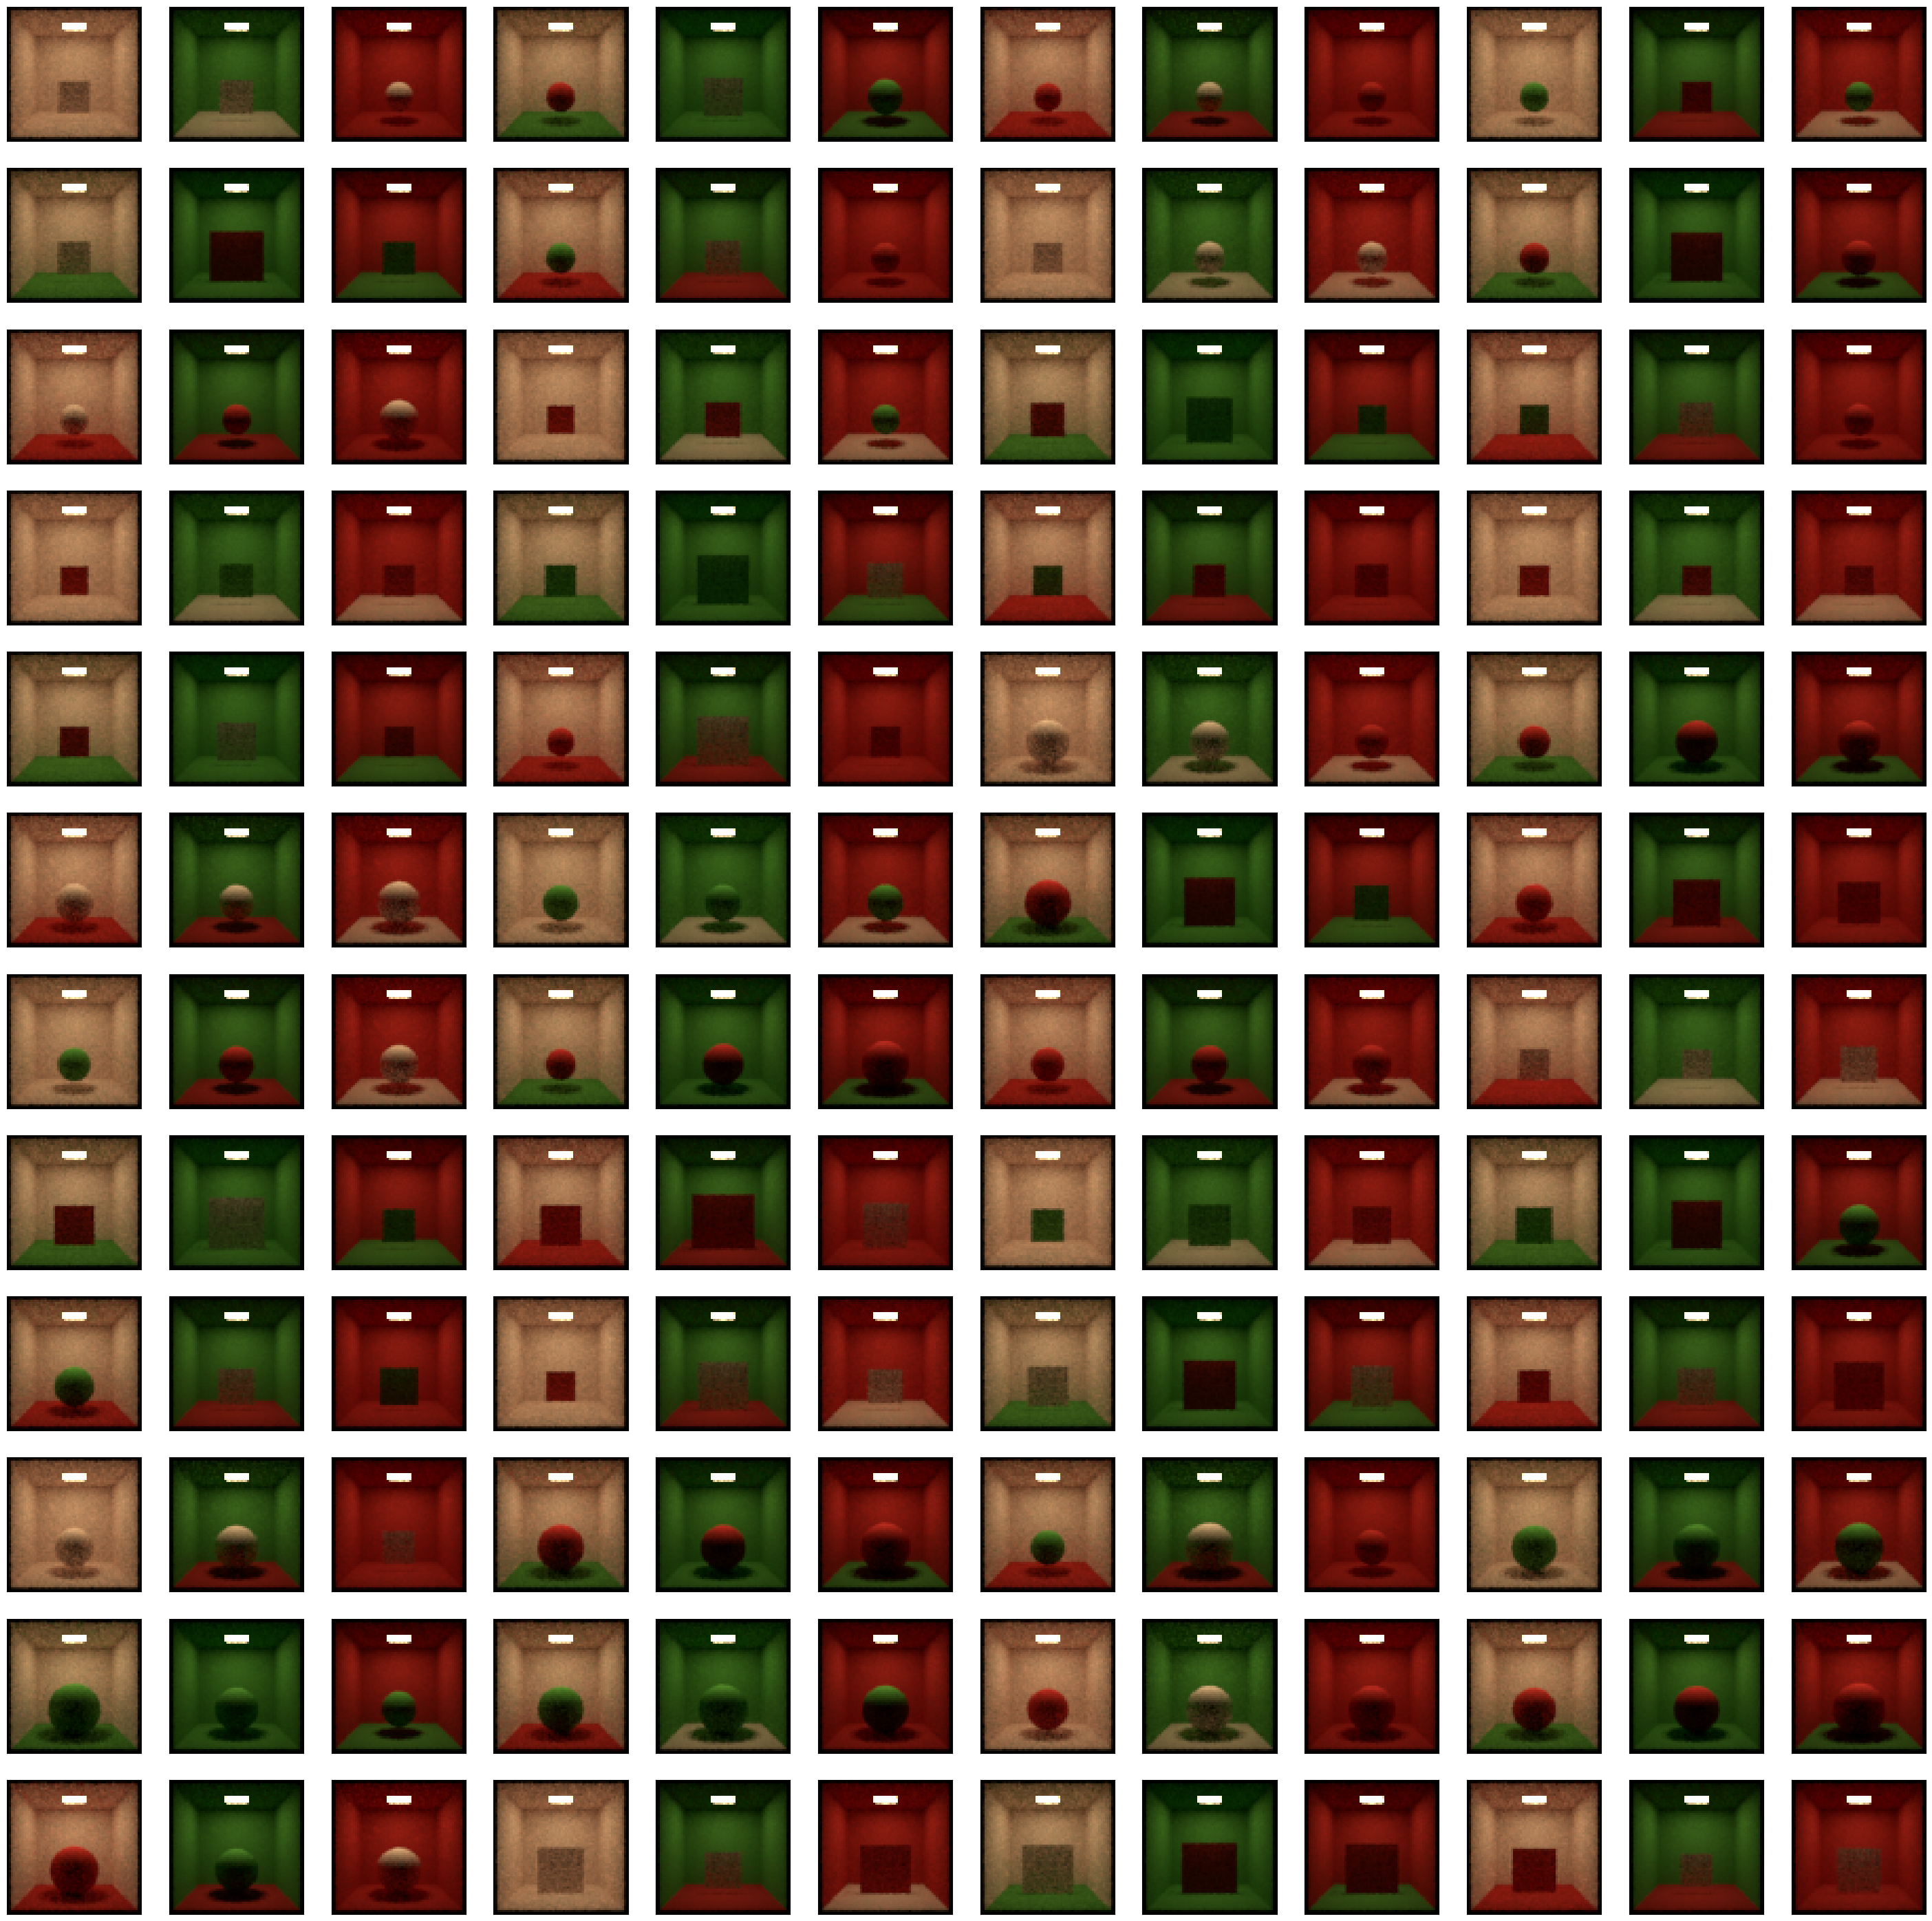

In [56]:
display(py"show_images_grid"(ori_inferred_images, 144, false))

# Util functions

In [30]:

py"""
import tqdm
import matplotlib.pyplot as plt
from scipy.special import softmax
import tensorflow_datasets as tfds

def mask_image_random(n):
    random_arrays = []
    for i in range(n):
        random_array = np.random.uniform(-1, 1, size=(64, 64, 3))
        random_arrays.append(random_array)
    return random_arrays

def display(array1, array2, seed=None, title='Inputs and outputs of the model', n=10):
    hopfield = False

    dim = array1[0].shape[0]
    # Displays ten random images from each one of the supplied arrays.
    if seed is not None:
        np.random.seed(seed)

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    fig = plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        if hopfield is True:
            plt.imshow(image1.reshape(dim, dim), cmap='binary', vmin=-1, vmax=1)
        else:
            plt.imshow(image1.reshape(dim, dim, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        if hopfield is True:
            plt.imshow(image2.reshape(dim, dim), cmap='binary', vmin=-1, vmax=1)
        else:
            plt.imshow(image2.reshape(dim, dim, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig.suptitle(title)
    plt.show()
    return fig

def preprocess(array):
    # Normalizes the supplied array and reshapes it into the appropriate format.
    array = array.astype("float64") / 255.0
    return array

def prepare_data(dataset, display=False, noise_factor=0.6, labels=False,train=None, test=None):
    # Normalize and reshape the data
    train_data = preprocess(train)
    test_data = preprocess(test)

    # Create a copy of the data with added noise
    noisy_train_data = noise(train_data, noise_factor=noise_factor)
    noisy_test_data = noise(test_data, noise_factor=noise_factor)

    # Display the train data and a version of it with added noise
    if display is True:
        display(train_data, noisy_train_data)

    if labels is False:
        return train_data, test_data, noisy_train_data, noisy_test_data

def plot_history(history, titles=True):
    recon_loss_values = history.history['reconstruction_loss']
    epochs = range(1, len(recon_loss_values) + 1)

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.set_ylabel("Reconstruction error")
    ax.plot(epochs, recon_loss_values, label='Reconstruction Error', color='red')

    if titles is True:
        lines, labels = ax.get_legend_handles_labels()
        plt.title('Reconstruction error over time')

    ax.set_xlabel('Epoch')
    plt.show()
    return fig
    
def noise(array, noise_factor=0.4, seed=None, gaussian=False, replacement_val=0):
    # Replace a fraction noise_factor of pixels with replacement_val or gaussian noise
    if seed is not None:
        np.random.seed(seed)
    shape = array.shape
    array = array.flatten()
    indices = np.random.choice(np.arange(array.size), replace=False,
                               size=int(array.size * noise_factor))
    if gaussian is True:
        array[indices] = np.random.normal(loc=0.5, scale=1.0, size=array[indices].shape)
    else:
        array[indices] = replacement_val
    array = array.reshape(shape)
    return np.clip(array, 0.0, 1.0)

def check_generative_recall(vae, test_data, noise_level=0.1):
    test_data = noise(test_data, noise_factor=noise_level)
    latents = vae.encoder.predict(test_data)
    predictions = vae.decoder.predict(latents[0])
    fig = display(test_data, predictions, title='Inputs and outputs for VAE')
    return fig

"""


In [43]:
py"""
import numpy as np
import tensorflow as tf
class ContinuousHopfield:
    def __init__(self, pat_size, beta=20, do_normalization=True):
        self.size = pat_size  # size of individual pattern
        self.beta = beta
        print(self.beta)
        self.max_norm = np.sqrt(self.size)
        if do_normalization:
            self.softmax = self.softmax_normalized
            self.energy = self.energy_normalized
        else:
            self.softmax = self.softmax_unnormalized
            self.energy = self.energy_unnormalized

        return

    def learn(self, patterns):
        # expects patterns as numpy arrays and stores them col-wise in pattern matrix 
        self.num_pat = len(patterns)
        assert (all(type(x) is np.ndarray for x in patterns)), 'not all input patterns are numpy arrays'
        assert (all(len(x.shape) == 2 for x in patterns)), 'not all input patterns have dimension 2'
        assert (all(1 == x.shape[1] for x in patterns)), 'not all input patterns have shape (-1,1) '
        self.patterns = np.array(patterns).squeeze(axis=-1).T  # save patterns col-wise
        # without squeeze axis would result in problem with one pattern
        # return -1*np.sum(np.exp([(self.patterns[:,ii].T @pattern)/self.max_norm for ii in range(self.patterns.shape[1])]))
        self.M = max(np.linalg.norm(vec) for vec in patterns)  # maximal norm of actually stored patterns
        return

    def retrieve(self, partial_pattern, max_iter=np.inf, thresh=0.5):
        # partial patterns have to be provided with None/0 at empty spots
        if partial_pattern.size != self.size:
            raise ValueError("Input pattern %r does not match state size: %d vs %d"
                             % (partial_pattern, len(partial_pattern), self.size))

        if None in partial_pattern:
            raise NotImplementedError("None elements not supported")

        assert type(partial_pattern) == np.ndarray, 'test pattern was not numpy array'
        assert len(partial_pattern.shape) == 2 and 1 == partial_pattern.shape[
            1], 'test pattern with shape %r is not a col-vector' % (partial_pattern.shape,)

        pat_old = partial_pattern.copy()
        iters = 0

        while iters < max_iter:
            pat_new = self.patterns @ self.softmax(self.beta * self.patterns.T @ pat_old)

            if np.count_nonzero(pat_old != pat_new) <= thresh:  # converged
                break
            else:
                pat_old = pat_new
            iters += 1

        return pat_new

    def softmax_unnormalized(z):
        return softmax(z)  # Scipy's softmax is numerically stable

    def softmax_normalized(self, z):
        return softmax(z / self.max_norm)

    @staticmethod
    def _lse(z, beta):
        return 1 / beta * np.log(np.sum(np.exp(beta * z)))

    def energy_unnormalized(self, pattern):
        return -1 * self._lse(self.patterns.T @ pattern, 1) + 0.5 * pattern.T @ pattern \
            + 1 / self.beta * np.log(self.num_pat) \
            + 0.5 * self.M ** 2

    def energy_normalized(self, pattern):
        # normalize dot product of patterns by 1/sqrt(pattern_size)
        return -1 * self._lse((self.patterns.T @ pattern) / self.max_norm, 1) + 0.5 * pattern.T @ pattern \
            + 1 / self.beta * np.log(self.num_pat) \
            + 0.5 * self.M ** 2

    def energy_landscape(self):
        for pat in product([1, -1], repeat=self.size):
            pat = np.array(pat)
            print("energy(%r)=%.3f" % (pat, self.energy(pat)))


"""

In [63]:
pat_size = 64*64*3
net = py"ContinuousHopfield"(pat_size)
net.learn(mitsuba_data)


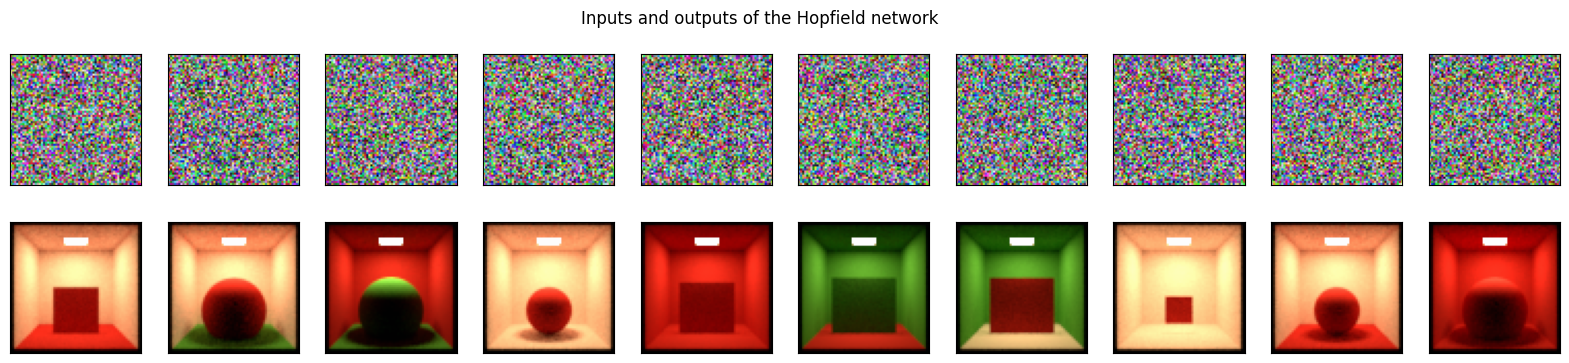

shape before reshaping: (64, 64, 3)
shape after reshaping: (12288, 1)
Sampling from modern Hopfield network.

In [64]:
n = size(mitsuba_data)[1]
np = py"np"
images_masked_np = py"mask_image_random"(n)
println("shape before reshaping: ", size(images_masked_np[1]))
images_masked_np = [reshape(array, (64*64*3,1)) for array in images_masked_np]
println("shape after reshaping: ", size(images_masked_np[1]))

print("Sampling from modern Hopfield network.")
replayed_inferences = []
tests = []
for test_ind in 1:n
    test = images_masked_np[test_ind]
    reconstructed = net.retrieve(test, max_iter=10)
    reconstructed = reshape(reconstructed, (1, 64, 64, 3))
    reconstructed = (reconstructed .+ 1) / 2
    push!(replayed_inferences, reconstructed)
    test = reshape(test, (1, 64, 64, 3))
    test = (test .+ 1) / 2
    push!(tests, test)
end

replayed_inferences = np.concatenate(replayed_inferences, axis=0)
tests = np.concatenate(tests, axis=0)

display(py"display"(tests, replayed_inferences,n=10, title="Inputs and outputs of the Hopfield network"))

# rescale predictions back to interval [0, 1]
# predictions = (predictions .+ 1) / 2

# save the predictions
# save("replayed_inferences.jld2", "replayed_inferences", replayed_inferences)

In [65]:
py"""
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tensorflow import keras
from tensorflow.keras import layers

class VAE(keras.Model):

    def __init__(self, encoder, decoder, kl_weighting=1, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weighting = kl_weighting
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = reconstruction_loss_fn(data, reconstruction)
            kl_loss = kl_loss_fn(z_mean, z_log_var, self.kl_weighting)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

def label_classifier(latents, labels, num=200):
        np.random.seed(1)
        x_train, x_test, y_train, y_test = train_test_split(latents[0], labels,
                                                            test_size=0.5, random_state=1)
        clf = make_pipeline(StandardScaler(), SVC())
        clf.fit(x_train[0:num], y_train[0:num])
        score = clf.score(x_test, y_test)
        return score
    
class DecodingHistory(keras.callbacks.Callback):
    
        def __init__(self, test_data):
            _, self.test_data, _, _, _, self.test_labels = prepare_data(dataset, labels=True)
            self.decoding_history = []
    
        def on_epoch_begin(self, epoch, logs=None):
            latents = self.model.encoder.predict(self.test_data)
            score = label_classifier(latents, self.test_labels)
            self.decoding_history.append(score)
    
    
class Sampling(layers.Layer):
        # Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    
        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def encoder_network_large(input_shape, latent_dim=100):
    input_img = layers.Input(shape=input_shape)
    x = layers.Dropout(0.2, input_shape=input_shape)(input_img)
    x = layers.Conv2D(32, 4, strides=(2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(64, 4, strides=(2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, 4, strides=(2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, 4, strides=(2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)

    z_mean = layers.Dense(latent_dim, name='mean')(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = keras.Model(input_img, [z_mean, z_log_var, z], name="encoder")
    return encoder, z_mean, z_log_var


def decoder_network_large(latent_dim=100):
    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(4096)(decoder_input)
    x = layers.Reshape((4, 4, 256))(x)

    x = layers.UpSampling2D((2, 2), interpolation='nearest')(x)
    x = layers.Conv2D(128, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.UpSampling2D((2, 2), interpolation='nearest')(x)
    x = layers.Conv2D(64, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.UpSampling2D((2, 2), interpolation='nearest')(x)
    x = layers.Conv2D(32, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.UpSampling2D((2, 2), interpolation='nearest')(x)
    x = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid')(x)

    decoder = keras.Model(decoder_input, x)
    return decoder


def build_encoder_decoder_large(latent_dim=5):
    input_shape = (64, 64, 3)
    encoder, z_mean, z_log_var = encoder_network_large(input_shape, latent_dim)
    decoder = decoder_network_large(latent_dim)
    return encoder, decoder

def kl_loss_fn(z_mean, z_log_var, kl_weighting):
    # take the sum across the n latent variables
    # then take the mean across the batch
    kl = K.mean(-0.5 * K.sum(1 + z_log_var \
                             - K.square(z_mean) \
                             - K.exp(z_log_var), axis=-1))
    return kl_weighting * kl


def reconstruction_loss_fn(x, t_decoded):
    # mean_absolute_error() returns result of dim (n_in_batch, pixels)
    # take the sum across the 64x64x3 pixels
    # take the mean across the batch
    data = x
    reconstruction = t_decoded
    # note that binary_crossentropy loss also gives good results
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
        keras.losses.mean_absolute_error(data, reconstruction), axis=(1, 2)))
    return reconstruction_loss
"""

Starting to train VAE.


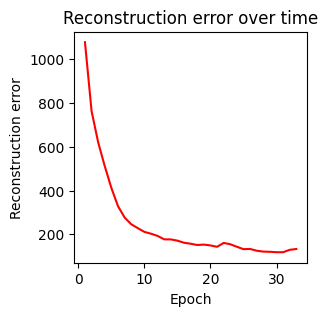

Input data shape:(270, 64, 64, 3)


20
20
20
20
20
20
Epoch 1/100
9/9 - 1s - loss: 1089.2642 - reconstruction_loss: 1077.8928 - kl_loss: 11.3712 - 1s/epoch - 165ms/step
Epoch 2/100
9/9 - 1s - loss: 780.6762 - reconstruction_loss: 763.1650 - kl_loss: 17.5112 - 761ms/epoch - 85ms/step
Epoch 3/100
9/9 - 1s - loss: 632.9240 - reconstruction_loss: 620.2936 - kl_loss: 12.6303 - 763ms/epoch - 85ms/step
Epoch 4/100
9/9 - 1s - loss: 532.4987 - reconstruction_loss: 511.1566 - kl_loss: 21.3421 - 741ms/epoch - 82ms/step
Epoch 5/100
9/9 - 1s - loss: 433.6378 - reconstruction_loss: 411.8913 - kl_loss: 21.7465 - 740ms/epoch - 82ms/step
Epoch 6/100
9/9 - 1s - loss: 356.5721 - reconstruction_loss: 329.0113 - kl_loss: 27.5608 - 740ms/epoch - 82ms/step
Epoch 7/100
9/9 - 1s - loss: 304.3703 - reconstruction_loss: 277.1180 - kl_loss: 27.2523 - 761ms/epoch - 85ms/step
Epoch 8/100
9/9 - 1s - loss: 272.3053 - reconstruction_loss: 246.2932 - kl_loss: 26.0121 - 759ms/epoch - 84ms/step
Epoch 9/100
9/9 - 1s - loss: 253.1872 - reconstruction_loss: 2

/Users/dongyu/.julia/packages/PyCall/KLzIO/src/pyeval.jl:81: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  make_fname(fname::AbstractString) = String(fname)


In [67]:
latent_dim = 20
keras = py"keras"
kl_weighting=1
lr=0.001
generative_epochs=50
println("Starting to train VAE.")
# build VAE with latent_dim latent variables
encoder, decoder = py"build_encoder_decoder_large"(latent_dim=latent_dim)
vae = py"VAE"(encoder, decoder, kl_weighting)
# jit_compile set to False to run on MacOS
opt = keras.optimizers.Adam(lr=lr, amsgrad=1, jit_compile=0)
vae.compile(optimizer=opt)
history = keras.callbacks.History()
# stop training if no loss improvement for three epochs
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=3)
println("Input data shape:", size(replayed_inferences))

# fit VAE
vae.fit(replayed_inferences, epochs=generative_epochs, verbose=2, batch_size=32,callbacks=[history, early_stopping])

vae.encoder.save_weights("model_weights/mitsuba_encoder.h5")
vae.decoder.save_weights("model_weights/mitsuba_decoder.h5")

display(py"plot_history"(history))

# pickle.dump(history.history['reconstruction_loss'], open("./outputs/history.pkl", "wb"))


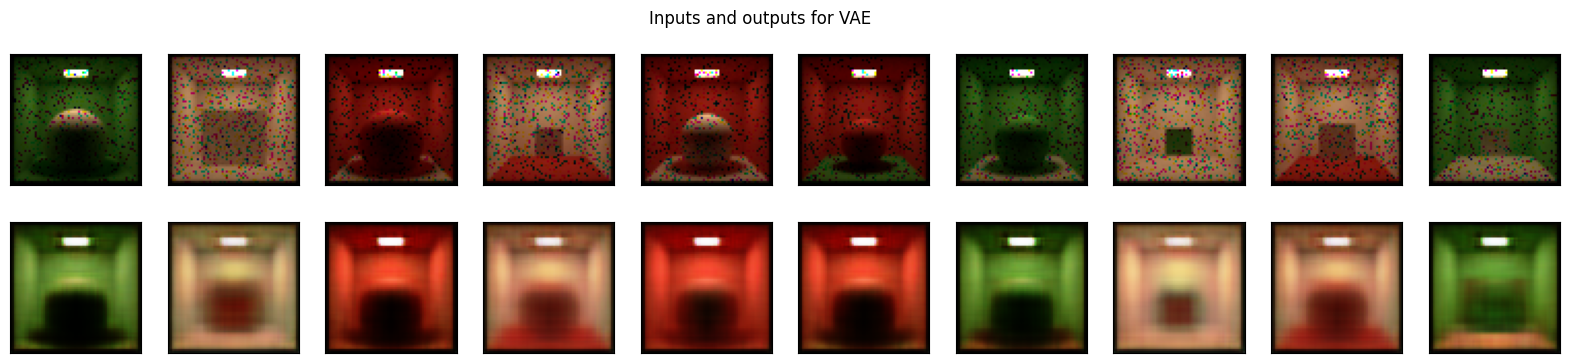

9/9 [==============================] - 0s 17ms/step


In [74]:
# convert the values in mitsuba_data from [0, 1] to [0, 255]
print("Recalling using noisy original images.")
display(py"check_generative_recall"(vae, ori_mitsuba_data, noise_level=0.1))

# latents = vae.encoder.predict(test_data)